In [2]:
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.multitest as smm

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

In [5]:
# 删除离群点
def remove_outliers(df, multiplier=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - multiplier * IQR)) | (df > (Q3 + multiplier * IQR))).any(axis=1)]


def loadcsv(rett_type, stain_type):
    loadpath_RETT = f"tables/features_chromatinCAM/RETT_{rett_type}_{stain_type}.csv"
    loadpath_CTRL = f"tables/features_chromatinCAM/CTRL_{stain_type}.csv"

    # 读取 CSV 文件
    df_RETT = pd.read_csv(loadpath_RETT).dropna()  # 删除包含 NaN 的样本
    df_CTRL = pd.read_csv(loadpath_CTRL).dropna()  # 删除包含 NaN 的样本
    print(f"LOAD {loadpath_RETT} {df_RETT.shape}")
    print(f"LOAD {loadpath_CTRL} {df_CTRL.shape}")
    
#     # 删除离群点
#     df_RETT_filtered = remove_outliers(df_RETT_scaled, multiplier=2)
#     df_CTRL_filtered = remove_outliers(df_CTRL_scaled, multiplier=2)
#     print(f"remove outliers {df_RETT_filtered.shape}, {df_CTRL_filtered.shape}")

#   添加状态标签
    df_RETT['State'] = 'RETT'
    df_CTRL['State'] = 'CTRL'
    
    # 合并数据
    df_combined = pd.concat([df_CTRL, df_RETT])
    
    return df_combined, df_RETT, df_CTRL

In [6]:
def loadcsv_Standard(rett_type, stain_type):
    loadpath_RETT = f"tables/features_chromatinCAM/RETT_{rett_type}_{stain_type}.csv"
    loadpath_CTRL = f"tables/features_chromatinCAM/CTRL_{stain_type}.csv"
    
    # 读取 CSV 文件
    df_RETT = pd.read_csv(loadpath_RETT).dropna()  # 删除包含 NaN 的样本
    df_CTRL = pd.read_csv(loadpath_CTRL).dropna()  # 删除包含 NaN 的样本
    print(f"LOAD {loadpath_RETT} {df_RETT.shape}")
    print(f"LOAD {loadpath_CTRL} {df_CTRL.shape}")
    
    # 标准化数据
    scaler = StandardScaler()
    df_RETT_scaled = scaler.fit_transform(df_RETT)
    df_CTRL_scaled = scaler.fit_transform(df_CTRL)
    # 将标准化后的数据转换回 DataFrame
    df_RETT_scaled = pd.DataFrame(df_RETT_scaled, columns=df_RETT.columns)
    df_CTRL_scaled = pd.DataFrame(df_CTRL_scaled, columns=df_CTRL.columns)

    # 添加状态标签
    df_RETT = df_RETT_scaled.copy()
    df_CTRL = df_CTRL_scaled.copy()
    df_RETT['State'] = 'RETT'
    df_CTRL['State'] = 'CTRL'
    
    # 合并数据
    df_combined = pd.concat([df_CTRL, df_RETT])
    
    return df_combined, df_RETT, df_CTRL

In [7]:
rett_type = "HPS9999"
stain_type = "H3K27ac"

df_combined, df_RETT, df_CTRL = loadcsv(rett_type, stain_type)

features = df_CTRL.columns.tolist()
for i in range(len(features)):
    print(i, features[i])
    
print("len(features): ", len(features))
df_combined

LOAD tables/features_chromatinCAM/RETT_HPS9999_H3K27ac.csv (3486, 5)
LOAD tables/features_chromatinCAM/CTRL_H3K27ac.csv (1567, 5)
0 number_of_cc
1 nuclear_area
2 heterochromatin_fraction
3 relative_heterochromatin_intensity
4 relative_heterochromatin_fraction
5 State
len(features):  6


number_of_cc  nuclear_area  heterochromatin_fraction  \
0               43         42214                  0.039631   
1               43         42214                  0.039631   
2               43         42214                  0.039631   
3               43         42214                  0.039631   
4               43         42214                  0.039631   
...            ...           ...                       ...   
3481            98         28537                  0.106143   
3482            98         28537                  0.106143   
3483            98         28537                  0.106143   
3484            98         28537                  0.106143   
3485            98         28537                  0.106143   

      relative_heterochromatin_intensity  relative_heterochromatin_fraction  \
0                               1.170572                           0.046391   
1                               1.170572                           0.046391   
2                               1.170572                           0.046391   
3                               1.170572                           0.046391   
4                               1.170572                           0.046391   
...                                  ...                                ...   
3481                            1.229541                           0.130507   
3482                            1.229541                           0.130507   
3483                            1.229541                           0.130507   
3484                            1.229541                           0.130507   
3485                            1.229541                           0.130507   

     State  
0     CTRL  
1     CTRL  
2     CTRL  
3     CTRL  
4     CTRL  
...    ...  
3481  RETT  
3482  RETT  
3483  RETT  
3484  RETT  
3485  RETT  

[5053 rows x 6 columns]

In [8]:
from sklearn.decomposition import PCA

def validate_pca(df_combined, df_RETT, df_CTRL):
    print("📊 PCA")
    # 提取特征数据
    features = df_combined.drop('State', axis=1)

    # 应用 PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(features)
    principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

    # 计算贡献率
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained variance ratio:", explained_variance_ratio)

    # 获取加载矩阵
    loading_matrix = pca.components_.T
    loading_df = pd.DataFrame(loading_matrix, columns=['PC1', 'PC2'], index=features.columns)

    # 可视化加载矩阵
    plt.figure(figsize=(16, 12))
    sns.heatmap(loading_df, annot=True, cmap='coolwarm')
    plt.title('PCA Loading Matrix')
    plt.savefig(f'tables/features_chromatin/PCA_Matrix_{rett_type}_{stain_type}.png', dpi=300)
    plt.show()

    # 重置索引以确保对齐
    state_df = df_combined[['State']].reset_index(drop=True)
    finalDf = pd.concat([principalDf, state_df], axis=1)

    # 使用 Seaborn 绘制 PCA 结果图
    sns.scatterplot(data=finalDf, x='principal component 1', y='principal component 2', hue='State')
    plt.title('PCA of Dataset by State')
    plt.savefig(f'tables/features_chromatin/PCA_{rett_type}_{stain_type}.png', dpi=300)
    plt.show()

In [9]:
from scipy.stats import ttest_ind

def validate_ttest(df_combined, df_RETT, df_CTRL):
    print("📊 ttest")
    # 初始化存储 p 值的列表
    p_values = []

    # 进行 t-检验
    for column in df_CTRL.columns[:-1]:  # 忽略 'State' 列
        t_stat, p_val = ttest_ind(
            df_CTRL[column], 
            df_RETT[column],
            equal_var=False  # 可以假设不等方差
        )
        p_values.append((column, p_val))

    # 将 p 值转化为 DataFrame
    p_values_df = pd.DataFrame(p_values, columns=['Feature', 'p_value'])

    # 提取原始 p 值列表
    p_values_list = p_values_df['p_value'].tolist()

    # 进行校正
    rej, pval_corr = smm.multipletests(p_values_list, alpha=0.05, method='fdr_bh')[:2]

    # 将校正后的 p 值添加回 DataFrame
    p_values_df['p_corrected'] = pval_corr

    # 筛选显著特征（例如校正后 p < 0.02）
    significant_features = p_values_df[p_values_df['p_corrected'] < 0.02]

    # 按 p 值排序
    significant_features = significant_features.sort_values(by='p_corrected')
    significant_features = pd.DataFrame(significant_features)
    
    # 打印 DataFrame
    print("significant_features: ", len(significant_features))
    print(significant_features.to_string(index=False))

#     # 可视化显著特征的 p 值
#     plt.figure(figsize=(16, 10))
#     sns.barplot(x='p_corrected', y='Feature', data=significant_features, palette='viridis')
#     plt.title('Significant Features Differentiating CTRL and RETT')
#     plt.xlabel('p_value_corrected')
#     plt.ylabel('Features')
#     plt.axvline(x=0.02, color='r', linestyle='--')
#     plt.savefig(f'{loadpath}/{savename}_ttest.png', dpi=300)
#     plt.show()

In [10]:
from scipy.stats import mannwhitneyu

def validate_mannwhitneyutest(df_combined, df_RETT, df_CTRL):
    print("📊 Mann-Whitney U test")
    p_values = []

    for column in df_CTRL.columns[:-1]:
        stat, p_val = mannwhitneyu(df_CTRL[column], df_RETT[column], alternative='two-sided')
        p_values.append((column, p_val))

    p_values_df = pd.DataFrame(p_values, columns=['Feature', 'p_value'])

    p_values_list = p_values_df['p_value'].tolist()
    rej, pval_corr = smm.multipletests(p_values_list, alpha=0.05, method='fdr_bh')[:2]
    p_values_df['p_corrected'] = pval_corr

    significant_features = p_values_df[p_values_df['p_corrected'] < 0.02]
    significant_features = significant_features.sort_values(by='p_corrected')
    significant_features = pd.DataFrame(significant_features)
    
    # 打印 DataFrame
    print("significant_features: ", len(significant_features))
    print(significant_features.to_string(index=False))

#     plt.figure(figsize=(16, 10))
#     sns.barplot(x='p_corrected', y='Feature', data=significant_features, palette='viridis')
#     plt.title('Significant Features Differentiating CTRL and RETT')
#     plt.xlabel('p_value_corrected')
#     plt.ylabel('Features')
#     plt.axvline(x=0.02, color='r', linestyle='--')
#     plt.savefig(f'{loadpath}/{savename}_mannwhitneyutest.png', dpi=300)
#     plt.show()

# Feature image

In [18]:
# Feature image
# for rett_type in ["HPS3042", "HPS3049", "HPS3084", "HPS9999"]:
for rett_type in ["HPS9999"]:
    print("🦠🦠🦠 ", rett_type)
    for stain_type in ["H3K27ac", "CTCF", "Dapi"]:
        savename = f"Feature_{stain_type}"
        df_combined, df_RETT, df_CTRL = loadcsv(rett_type, stain_type)
        
        validate_ttest(df_combined, df_RETT, df_CTRL)

        validate_mannwhitneyutest(df_combined, df_RETT, df_CTRL)
        
        print("############################################################")
        print("")

🦠🦠🦠  HPS9999
LOAD tables/features_chromatinCAM/RETT_HPS9999_H3K27ac.csv (3486, 5)
LOAD tables/features_chromatinCAM/CTRL_H3K27ac.csv (1567, 5)
📊 ttest
significant_features:  4
                           Feature      p_value  p_corrected
relative_heterochromatin_intensity 1.516123e-80 7.580617e-80
                      number_of_cc 5.334183e-27 1.333546e-26
 relative_heterochromatin_fraction 4.426783e-20 7.377971e-20
          heterochromatin_fraction 7.407624e-11 9.259530e-11
📊 Mann-Whitney U test
significant_features:  4
                           Feature       p_value   p_corrected
relative_heterochromatin_intensity 7.342936e-132 3.671468e-131
 relative_heterochromatin_fraction  3.452602e-35  8.631505e-35
                      number_of_cc  4.222981e-25  7.038301e-25
          heterochromatin_fraction  7.427422e-19  9.284278e-19
############################################################

LOAD tables/features_chromatinCAM/RETT_HPS9999_CTCF.csv (3518, 5)
LOAD tables/features_chromati

🦠🦠🦠  HPS9999
LOAD tables/features_chromatinCAM/RETT_HPS9999_H3K27ac.csv (3486, 5)
LOAD tables/features_chromatinCAM/CTRL_H3K27ac.csv (1567, 5)
📊 PCA
Explained variance ratio: [0.60988737 0.23674662]


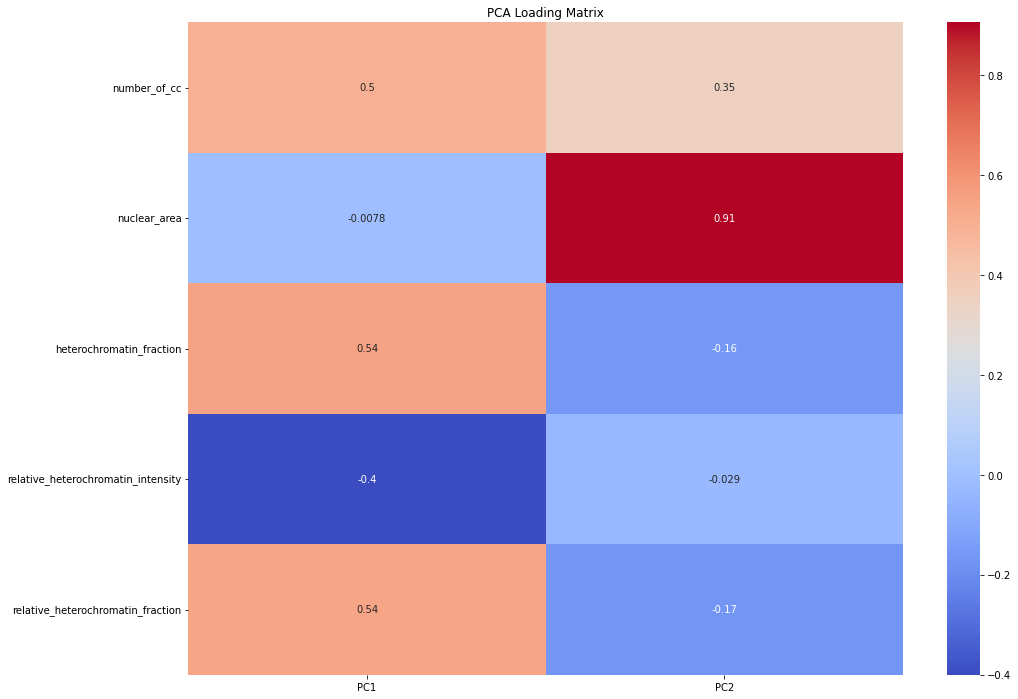

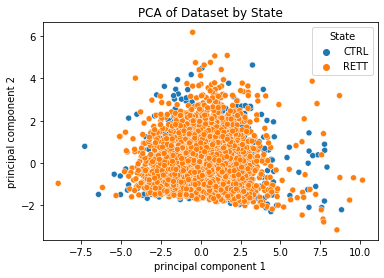

############################################################

LOAD tables/features_chromatinCAM/RETT_HPS9999_CTCF.csv (3518, 5)
LOAD tables/features_chromatinCAM/CTRL_CTCF.csv (1591, 5)
📊 PCA
Explained variance ratio: [0.62503968 0.24750338]


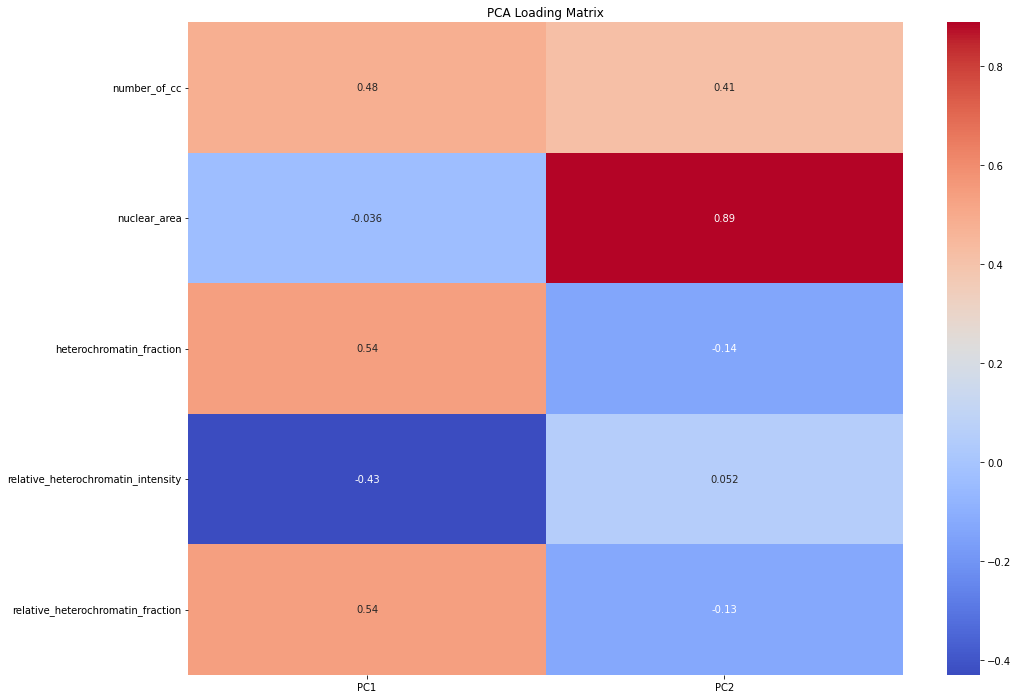

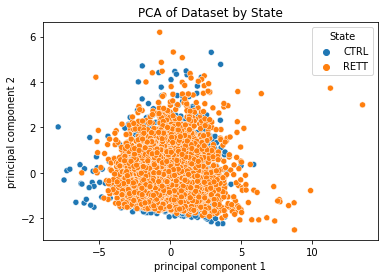

############################################################

LOAD tables/features_chromatinCAM/RETT_HPS9999_Dapi.csv (3478, 5)
LOAD tables/features_chromatinCAM/CTRL_Dapi.csv (1515, 5)
📊 PCA
Explained variance ratio: [0.53095167 0.26185243]


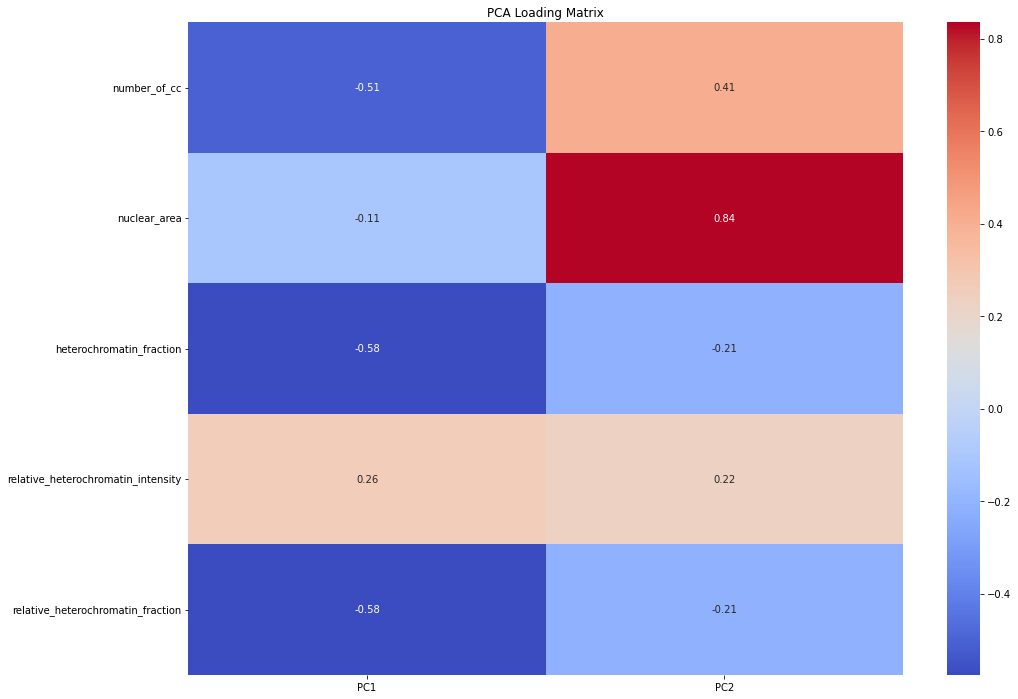

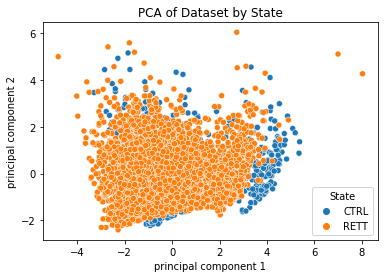

############################################################



In [19]:
# Feature image
# for rett_type in ["HPS3042", "HPS3049", "HPS3084", "HPS9999"]:
for rett_type in ["HPS9999"]:
    print("🦠🦠🦠 ", rett_type)
    for stain_type in ["H3K27ac", "CTCF", "Dapi"]:
        df_combined, df_RETT, df_CTRL = loadcsv_Standard(rett_type, stain_type)
        
        validate_pca(df_combined, df_RETT, df_CTRL)
        
        print("############################################################")
        print("")

# BOX 箱型图

In [20]:
def validata_boxplot(data_all, feature):
    # 假设 data_all 是之前整理好的 DataFrame
    unique_stains = data_all['Stain_Type'].unique()  # 获取所有染色类型
    p_values = []
    # 计算每种染色类型的 p 值
    for stain in unique_stains:
        group_ctrl = data_all[(data_all['State'] == 'CTRL') & (data_all['Stain_Type'] == stain)][feature]
        group_rett = data_all[(data_all['State'] == 'RETT') & (data_all['Stain_Type'] == stain)][feature]
        _, p_val = ttest_ind(group_ctrl, group_rett)
        p_values.append(p_val)
    for i in range(len(unique_stains)):
        print(f"p-value {unique_stains[i]}: {p_values[i]}")

    # 设置颜色
    palette_colors = {"CTRL": sns.color_palette(palette='bwr')[0], 
                      "RETT": sns.color_palette(palette='Pastel1')[0]}  # CTRL 使用绿色，RETT 使用紫色
    # 绘制箱型图
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Stain_Type', y=feature, hue='State', data=data_all, palette=palette_colors)
    plt.title(f'{feature} with Stains and Cell States')
    plt.ylabel(f'{feature}')
    plt.xlabel('Stain Type')
    plt.legend(title='Cell State')
    plt.savefig(f'tables/features_chromatinCAM/{rett_type}_{feature}.png', dpi=300)
    plt.show()

🦠🦠🦠  HPS9999
LOAD tables/features_chromatinCAM/RETT_HPS9999_H3K27ac.csv (3486, 5)
LOAD tables/features_chromatinCAM/CTRL_H3K27ac.csv (1567, 5)
LOAD tables/features_chromatinCAM/RETT_HPS9999_CTCF.csv (3518, 5)
LOAD tables/features_chromatinCAM/CTRL_CTCF.csv (1591, 5)
LOAD tables/features_chromatinCAM/RETT_HPS9999_Dapi.csv (3478, 5)
LOAD tables/features_chromatinCAM/CTRL_Dapi.csv (1515, 5)
['number_of_cc', 'nuclear_area', 'heterochromatin_fraction', 'relative_heterochromatin_intensity', 'relative_heterochromatin_fraction', 'State']
💠 Fearure - HPS9999 - number_of_cc
p-value H3K27ac: 6.3018810533954376e-24
p-value CTCF: 6.106864880759291e-40
p-value Dapi: 4.694215233307169e-25


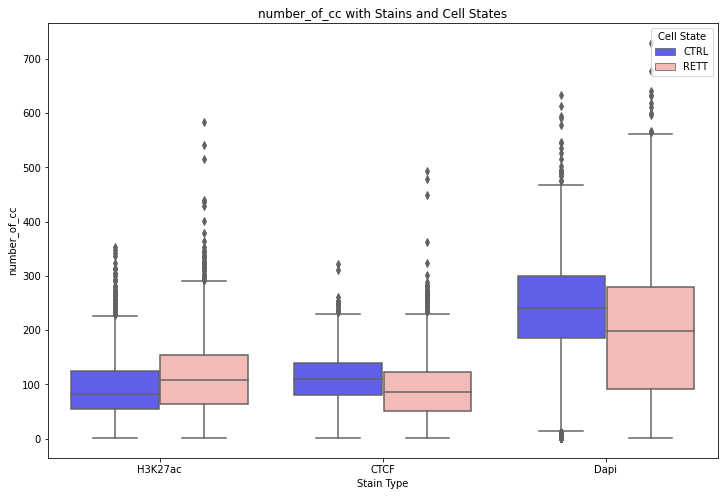

💠 Fearure - HPS9999 - nuclear_area
p-value H3K27ac: 0.19009184905779816
p-value CTCF: 0.20466567356929113
p-value Dapi: 0.1527936390351439


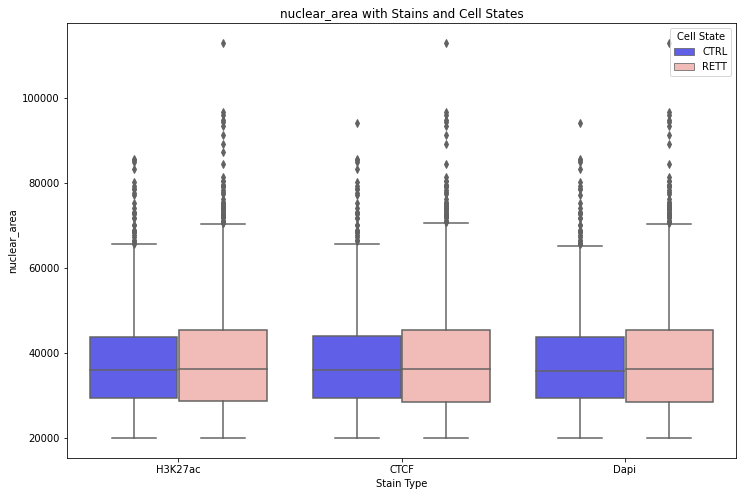

💠 Fearure - HPS9999 - heterochromatin_fraction
p-value H3K27ac: 7.362634307593647e-11
p-value CTCF: 1.2433552977937518e-19
p-value Dapi: 5.591255966727077e-191


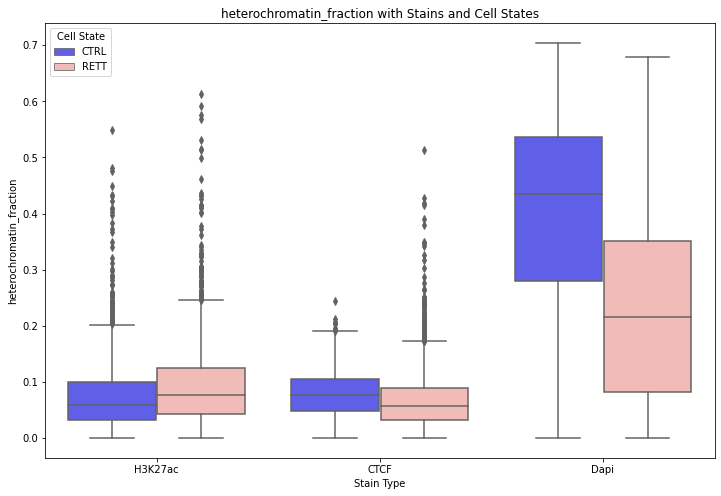

💠 Fearure - HPS9999 - relative_heterochromatin_intensity
p-value H3K27ac: 3.675567762070614e-65
p-value CTCF: 3.442719557457329e-98
p-value Dapi: 0.908973452797713


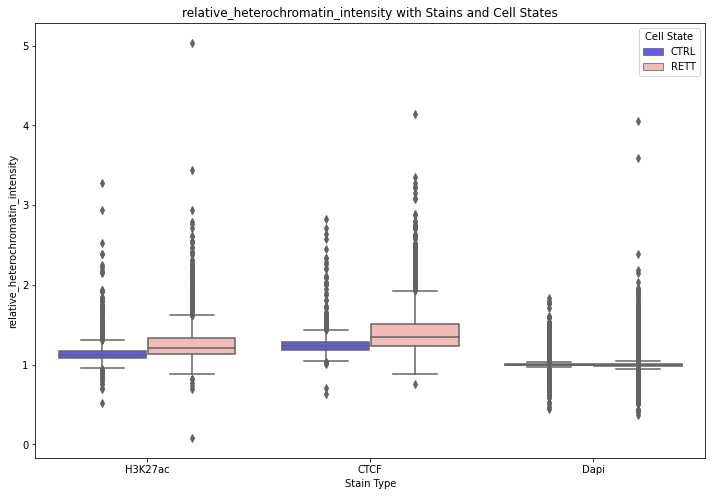

💠 Fearure - HPS9999 - relative_heterochromatin_fraction
p-value H3K27ac: 1.527962221733092e-20
p-value CTCF: 1.7257896349629567e-13
p-value Dapi: 5.697241348115407e-193


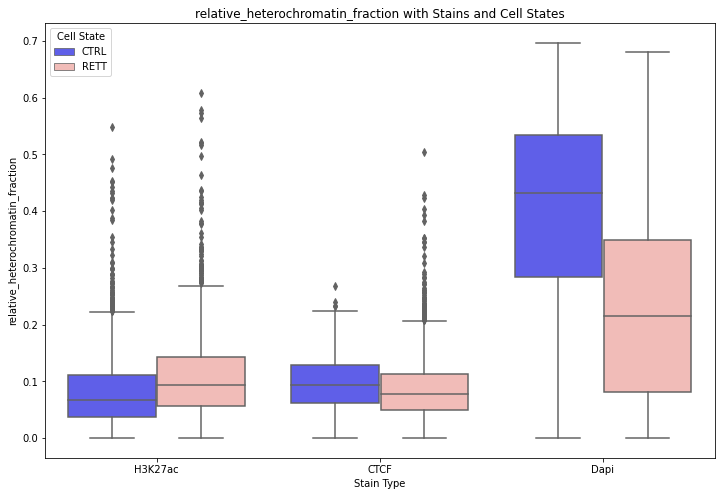

In [21]:
# 创建一个空的 DataFrame 用于存放所有数据
data_all = pd.DataFrame()

# for rett_type in ["HPS3042", "HPS3049", "HPS3084", "HPS9999"]:
for rett_type in ["HPS9999"]:
    print("🦠🦠🦠 ", rett_type)
    for stain_type in ["H3K27ac", "CTCF", "Dapi"]:
        # 假设 loadcsv 函数返回的 df_combined 已包含状态标签
        df_combined, df_RETT, df_CTRL = loadcsv(rett_type, stain_type)
        df_combined['Stain_Type'] = stain_type  # 添加染色类型列
        data_all = pd.concat([data_all, df_combined])  # 合并数据

    features = df_CTRL.columns.tolist()
    print(features)
    for feature in features[:-1]:
        print(f"💠 Fearure - {rett_type} - {feature}")
        validata_boxplot(data_all, feature)